# Gaussian Mixture Models (GMM) Implementation

## 1. Theoretical Foundation
A Gaussian Mixture Model assumes that all data points $X$ are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.


For a given data point $x_n$, GMM computes the probability that it belongs to cluster $k$:

$$P(z_n = k \mid x_n) = \frac{\pi_k \cdot \mathcal{N}(x_n | \mu_k, \Sigma_k)}{\sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(x_n | \mu_k, \Sigma_k)}$$


For a dataset $X$ of $N$ samples and $D$ dimensions, we define the probability of a single data point $x$ as:
$$p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)$$

Where:
* $\pi_k$: Mixing coefficient for cluster $k$ (Prior probability), subject to $\sum \pi_k = 1$.
* $\mathcal{N}(x | \mu_k, \Sigma_k)$: The Multivariate Gaussian density function.

### Initialization Strategy
Since the EM algorithm is sensitive to initialization (local optima), we initialize:
1.  **Means ($\mu$)**: Randomly selected samples from the dataset .
2.  **Weights ($\pi$)**: Uniform initialization $\pi_k = 1/K$.
3.  **Covariance ($\Sigma$)**: Initialized using the empirical covariance of the entire dataset to ensure we start with a valid positive-definite matrix.

In [ ]:
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

class GMM:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4, covariance_type='full', reg_covar=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.covariance_type = covariance_type
        self.reg_covar = reg_covar  # Epsilon for numerical stability
        
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.log_likelihood_history_ = []

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape
        
        # 1. Initialize Means: Choose K random points
        rng = np.random.default_rng(42) # Returns Random Number Generator Object 
        random_indices = rng.choice(n_samples, self.n_components, replace=False) # the replace argument ensures, we don't replace a previously selected variable with a new one
        self.means_ = X[random_indices]                                          # Therefore, preventing two centers coming out to be the same value
        
        # 2. Initialize Weights: Uniformly (1/K)
        self.weights_ = np.full(self.n_components, 1 / self.n_components) # This is the Prior Probability Matrix/Array (pi_k). All values will be 1/k initially
        
        # 3. Initialize Covariances based on type (Start with dataset empirical covariance)
        avg_cov = np.cov(X.T) + np.eye(n_features) * self.reg_covar
        
        if self.covariance_type == 'full':
            self.covariances_ = np.array([avg_cov for _ in range(self.n_components)])
        elif self.covariance_type == 'tied':
            self.covariances_ = avg_cov
        elif self.covariance_type == 'diagonal':
            self.covariances_ = np.array([np.diag(avg_cov) for _ in range(self.n_components)])
        elif self.covariance_type == 'spherical':
            mean_var = np.mean(np.diag(avg_cov))
            self.covariances_ = np.full(self.n_components, mean_var)

print("GMM Class initialized.")

GMM Class initialized.


### Technical Note: Initialization & Stability

**1. Why use the dataset's covariance for initialization?**
Instead of initializing covariances to the Identity matrix ($I$), we use the empirical covariance of the entire dataset (`np.cov(X.T)`).
* **Reasoning:** The Identity matrix assumes features have unit variance (1.0). Real data might have variances of 0.001 or 1000. Using the dataset's actual spread gives the GMM a realistic starting "scale," leading to faster convergence.

**2. The Role of `reg_covar` (Regularization)**
The assignment requires handling numerical stability . We add `reg_covar` ($\epsilon \approx 10^{-6}$) to the diagonal of covariance matrices.
$$\Sigma_{safe} = \Sigma + \epsilon I$$
* **Without this:** If a cluster collapses to a single point, variance $\to$ 0. The probability density function involves $\frac{1}{|\Sigma|}$ and $\Sigma^{-1}$, causing division by zero errors.
* **With this:** The matrix is guaranteed to be **Positive Definite** (invertible).

**3. Geometric Interpretation of Covariance Types**
* **Full:** $\mathcal{O}(K \cdot D^2)$ parameters. Most flexible; fits complex shapes but prone to overfitting on small data.
* **Diagonal:** $\mathcal{O}(K \cdot D)$ parameters. Assumes features are uncorrelated (Naive Bayes assumption).
* **Spherical:** $\mathcal{O}(K)$ parameters. Least flexible; effectively performs "Soft K-Means."
  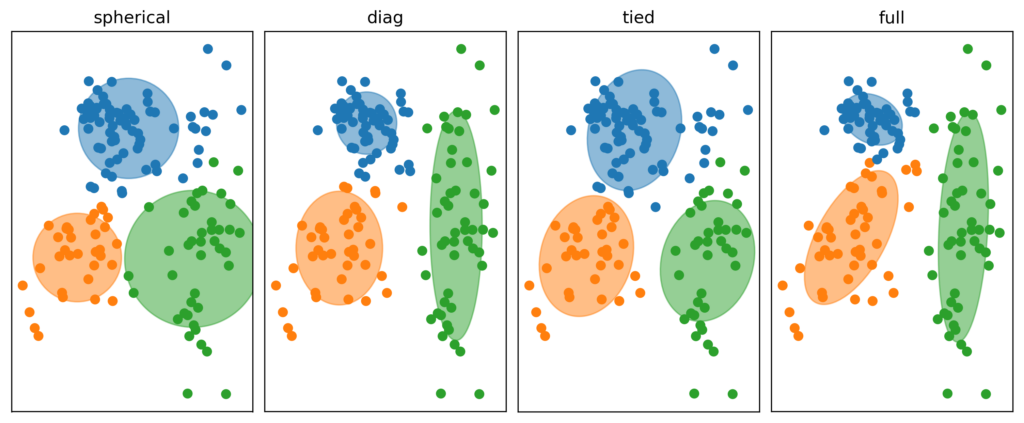

## 2. The Log-Probability & Numerical Stability

To compute the responsibilities in the E-step, we first need the log-probability of every sample under each Gaussian component.

### The Multivariate Gaussian PDF
The standard formula for the probability density is:
$$\mathcal{N}(x|\mu, \Sigma) = \frac{1}{(2\pi)^{D/2} |\Sigma|^{1/2}} \exp \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)$$

Working with probabilities directly causes numerical underflow (values become $0.0$). Instead, we work with the **Log-Probability**:
$$\ln \mathcal{N} = \underbrace{-\frac{D}{2}\ln(2\pi)}_{\text{Constant}} \underbrace{- \frac{1}{2}\ln|\Sigma|}_{\text{Log-Determinant}} \underbrace{- \frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)}_{\text{Mahalanobis Distance}}$$

### Handling Covariance Constraints
Computing the Determinant ($|\Sigma|$) and Inverse ($\Sigma^{-1}$) directly is computationally expensive ($O(D^3)$) and unstable. We optimize this based on the covariance type .

#### 1. Full Covariance (The Cholesky Method)
When $\Sigma$ is a full matrix, we avoid direct inversion. We use the **Cholesky Decomposition**, which factors the matrix into a lower triangular matrix $L$ such that $\Sigma = L L^T$.

**A. Log-Determinant**
Since $|\Sigma| = |L||L^T| = |L|^2$, and the determinant of a triangular matrix is the product of its diagonal:
$$\ln|\Sigma| = 2 \sum_{i=1}^D \ln(L_{ii})$$

**B. Deep Dive: The Linear Solve Trick (Mahalanobis Distance)**
We need to calculate: $(x - \mu)^T \Sigma^{-1} (x - \mu)$.
Substituting $\Sigma = L L^T$:
$$(x - \mu)^T (L L^T)^{-1} (x - \mu) = (x - \mu)^T (L^{-1})^T L^{-1} (x - \mu)$$
Let vector $y = L^{-1} (x - \mu)$. Then the equation becomes simply $y^T y$ (the squared length of vector $y$).

**Code Explanation:**
* `diff = X - mu`: This represents $(x - \mu)$.
* `sol = np.linalg.solve(L, diff.T).T`: Instead of calculating $L^{-1}$ (which is slow), we solve the linear equation $L y = (x - \mu)$. This is numerically faster and more precise.
    * Mathematically: $y = L^{-1} \text{diff}$.
* `mahalanobis = np.sum(sol**2, axis=1)`: This calculates $y^T y$ by squaring all elements of $y$ and summing them.

#### 2. Diagonal Covariance (Independent Features)
Here, $\Sigma$ is zero everywhere except the diagonal.
$$\Sigma = \text{diag}(\sigma_1^2, \sigma_2^2, \dots, \sigma_D^2)$$
* **Log-Determinant:** The determinant is simply the product of the diagonal elements.
  $$\ln|\Sigma| = \sum_{j=1}^D \ln(\sigma_j^2)$$
* **Mahalanobis Distance:** The inverse is simply the reciprocal of the variances ($1/\sigma^2$). The matrix multiplication simplifies to a weighted sum of squared differences:
  $$(x - \mu)^T \Sigma^{-1} (x - \mu) = \sum_{j=1}^D \frac{(x_j - \mu_j)^2}{\sigma_j^2}$$

#### 3. Spherical Covariance (The Scalar Shortcut)
Here, the cluster is a perfect sphere, so $\Sigma = \sigma^2 I$ (a single scalar variance).
* **Log-Determinant:**
  $$\ln|\Sigma| = \ln((\sigma^2)^D) = D \cdot \ln(\sigma^2)$$
* **Mahalanobis Distance:** The inverse is $\frac{1}{\sigma^2} I$. The distance becomes standard Euclidean distance scaled by the variance:
  $$\frac{1}{\sigma^2} ||x - \mu||^2$$

### Deep Dive: The Linear Solve Trick (Mahalanobis Distance)

We need to calculate the Mahalanobis distance of a point $x$ from the cluster center $\mu$:
$$D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$$

Computing the inverse matrix $\Sigma^{-1}$ is computationally expensive ($O(N^3)$) and numerically unstable. We use the **Cholesky Decomposition** ($\Sigma = L L^T$) to transform the problem.

#### 1. The Algebraic Substitution
Substituting $\Sigma = L L^T$ into the distance formula:
$$D^2 = (x - \mu)^T (L L^T)^{-1} (x - \mu) = (x - \mu)^T (L^{-1})^T L^{-1} (x - \mu)$$

We can define a transformed vector $y$:
$$y = L^{-1} (x - \mu)$$
This simplifies the distance equation to a simple dot product (squared Euclidean distance):
$$D^2 = y^T y$$

#### 2. The Computational Trick
Instead of calculating $L^{-1}$ explicitly, we rearrange the definition $y = L^{-1} (x - \mu)$ into a system of linear equations:
$$L y = (x - \mu)$$
Since $L$ is a triangular matrix, we can solve for $y$ using **forward substitution**, which is significantly faster ($O(N^2)$) and more robust than matrix inversion.

#### 3. Mapping Code to Math
* `diff = X - mu`: Represents the vector $(x - \mu)$.
* `sol = np.linalg.solve(L, diff.T).T`: Solves the system $L y = \text{diff}$ to find $y$.
* `mahalanobis = np.sum(sol**2, axis=1)`: Computes $y^T y$ by squaring elements and summing.

In [ ]:
def _estimate_log_prob(self, X):
    n_samples, n_features = X.shape
    log_prob = np.zeros((n_samples, self.n_components))
    
    const_term = -0.5 * n_features * np.log(2 * np.pi)

    for k in range(self.n_components):
        mu = self.means_[k]
        
        # -- FULL COVARIANCE --
        if self.covariance_type == 'full':
            cov = self.covariances_[k] + np.eye(n_features) * self.reg_covar
            try:
                L = np.linalg.cholesky(cov)
                log_det_cov = 2 * np.sum(np.log(np.diagonal(L)))
                # Solve (L @ L.T) * x = (X - mu) -> L * y = diff -> y = L^-1 diff
                diff = X - mu
                sol = np.linalg.solve(L, diff.T).T 
                mahalanobis = np.sum(sol**2, axis=1)
            except np.linalg.LinAlgError:
                log_det_cov = np.nansum(np.log(np.diag(cov))) 
                mahalanobis = np.sum((diff @ np.linalg.inv(cov)) * diff, axis=1)

        # -- TIED COVARIANCE --
        elif self.covariance_type == 'tied':
            cov = self.covariances_ + np.eye(n_features) * self.reg_covar
            L = np.linalg.cholesky(cov)
            log_det_cov = 2 * np.sum(np.log(np.diagonal(L)))
            diff = X - mu
            sol = np.linalg.solve(L, diff.T).T
            mahalanobis = np.sum(sol**2, axis=1)

        # -- DIAGONAL COVARIANCE --
        elif self.covariance_type == 'diagonal':
            cov_diag = self.covariances_[k] + self.reg_covar
            log_det_cov = np.sum(np.log(cov_diag))
            diff = X - mu
            mahalanobis = np.sum((diff**2) / cov_diag, axis=1)

        # -- SPHERICAL COVARIANCE --
        elif self.covariance_type == 'spherical':
            cov_scalar = self.covariances_[k] + self.reg_covar
            log_det_cov = n_features * np.log(cov_scalar)
            diff = X - mu
            mahalanobis = np.sum(diff**2, axis=1) / cov_scalar
        
        log_prob[:, k] = const_term - 0.5 * (log_det_cov + mahalanobis)
    
    return log_prob

GMM._estimate_log_prob = _estimate_log_prob

## 3. The Expectation Step (E-Step)

We evaluate the posterior probability (responsibility) using Bayes' Theorem.
We define $\gamma(z_{nk})$ as the probability that point $n$ belongs to component $k$.

$$\gamma(z_{nk}) = p(z_k=1 | x_n) = \frac{\pi_k \mathcal{N}(x_n|\mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x_n|\mu_j, \Sigma_j)}$$

### The Log-Sum-Exp Trick
Directly computing the exponential of log-probabilities often results in underflow (values rounding to 0.0). We use the identity:
$$\log \left( \sum_i \exp(x_i) \right) = x_{max} + \log \left( \sum_i \exp(x_i - x_{max}) \right)$$

This shifts the exponents to a manageable range where the largest value is $e^0 = 1$.

### Deep Dive: The Log-Sum-Exp Trick

**The Problem:**
When calculating the denominator for responsibilities in the E-step, we need to sum probabilities:
$$\text{Sum} = \sum_{i=1}^K e^{x_i}$$
where $x_i$ is the log-probability. In high dimensions, $x_i$ is often a large negative number (e.g., $-1000$).
* Directly computing $e^{-1000}$ results in **Underflow** (the computer rounds it to $0.0$).
* If all terms underflow, the sum is $0.0$, leading to division-by-zero errors later.

**The Derivation:**
We want to compute $y = \log \left( \sum_{i} e^{x_i} \right)$ safely.
Let $x_{max} = \max_i(x_i)$. We can factor this term out algebraically:

1.  **Factor out $e^{x_{max}}$ inside the sum:**
    $$\sum_{i} e^{x_i} = \sum_{i} e^{x_i - x_{max} + x_{max}} = \sum_{i} \left( e^{x_{max}} \cdot e^{x_i - x_{max}} \right)$$
    $$\sum_{i} e^{x_i} = e^{x_{max}} \cdot \sum_{i} e^{x_i - x_{max}}$$

2.  **Take the logarithm of the whole expression:**
    $$\log \left( \sum_{i} e^{x_i} \right) = \log \left( e^{x_{max}} \cdot \sum_{i} e^{x_i - x_{max}} \right)$$

3.  **Apply the product rule $\log(ab) = \log(a) + \log(b)$:**
    $$\log \left( \sum_{i} e^{x_i} \right) = \log(e^{x_{max}}) + \log \left( \sum_{i} e^{x_i - x_{max}} \right)$$

4.  **Simplify $\log(e^x) = x$:**
    $$\log \left( \sum_{i} e^{x_i} \right) = x_{max} + \log \left( \sum_{i} e^{x_i - x_{max}} \right)$$

**Why This Works:**
By shifting all exponents by $x_{max}$:
* The largest term becomes $\exp(x_{max} - x_{max}) = e^0 = 1$.
* All other terms become $\exp(\text{negative number})$, which results in small values ($< 1$) but effectively avoids the "everything becomes zero" problem.
* The sum is guaranteed to be at least $1.0$, so $\log(\text{sum})$ is always valid (non-negative).

In [ ]:
def _e_step(self, X):
    # weighted_log_prob = ln(pi_k) + ln(N(x|k))
    weighted_log_prob =  np.log(self.weights_ + 1e-10) + self._estimate_log_prob(X) 
    
    # Log-Sum-Exp Trick for numerical stability
    log_prob_norm = np.max(weighted_log_prob, axis=1, keepdims=True)
    log_resp = weighted_log_prob - log_prob_norm
    log_prob_sum = log_prob_norm + np.log(np.sum(np.exp(log_resp), axis=1, keepdims=True))
    
    # Gamma (responsibilities) = exp(log_numerator - log_denominator)
    responsibilities = np.exp(weighted_log_prob - log_prob_sum)
    
    total_log_likelihood = np.sum(log_prob_sum)
    
    return total_log_likelihood, responsibilities

GMM._e_step = _e_step

## 4. The Maximization Step (M-Step)

We maximize the expected log-likelihood with respect to the parameters .

**1. Weights ($\pi_k$):**
Using Lagrange multipliers with the constraint $\sum \pi_k = 1$, we find:
$$\pi_k^{new} = \frac{N_k}{N}, \quad \text{where } N_k = \sum_{n=1}^{N} \gamma(z_{nk})$$

**2. Means ($\mu_k$):**
Taking the derivative of the log-likelihood with respect to $\mu_k$ and setting to 0:
$$\mu_k^{new} = \frac{1}{N_k} \sum_{n=1}^{N} \gamma(z_{nk}) x_n$$

**3. Covariances ($\Sigma_k$):**
The update depends on the constraint type :
* **Full:** $\Sigma_k = \frac{1}{N_k} \sum_{n} \gamma_{nk} (x_n - \mu_k)(x_n - \mu_k)^T$
* **Diagonal:** We only keep the diagonal of the Full update.
* **Tied:** We average the Full updates across all $K$ clusters: $\Sigma = \frac{1}{N} \sum_k N_k \Sigma_k$.
* **Spherical:** We average the variance across all $D$ dimensions: $\sigma_k^2 = \frac{1}{D} \text{Trace}(\Sigma_k^{full})$.

In [4]:
def _m_step(self, X, responsibilities):
    n_samples, n_features = X.shape
    
    # 1. Effective points per cluster
    nk = responsibilities.sum(axis=0) + 10 * np.finfo(responsibilities.dtype).eps
    
    # 2. Update Weights
    self.weights_ = nk / n_samples
    
    # 3. Update Means
    self.means_ = (responsibilities.T @ X) / nk[:, np.newaxis]
    
    # 4. Update Covariances
    if self.covariance_type == 'full':
        for k in range(self.n_components):
            diff = X - self.means_[k]
            cov = np.dot((diff * responsibilities[:, k:k+1]).T, diff) / nk[k]
            cov.flat[::n_features + 1] += self.reg_covar # Add epsilon
            self.covariances_[k] = cov
            
    elif self.covariance_type == 'tied':
        avg_cov = np.zeros((n_features, n_features))
        for k in range(self.n_components):
            diff = X - self.means_[k]
            cov = np.dot((diff * responsibilities[:, k:k+1]).T, diff)
            avg_cov += cov
        self.covariances_ = avg_cov / n_samples
        self.covariances_.flat[::n_features + 1] += self.reg_covar
        
    elif self.covariance_type == 'diagonal':
        avg_cov = np.empty((self.n_components, n_features))
        for k in range(self.n_components):
            diff = X - self.means_[k]
            avg_cov[k] = np.sum(responsibilities[:, k:k+1] * (diff**2), axis=0) / nk[k]
        self.covariances_ = avg_cov + self.reg_covar
        
    elif self.covariance_type == 'spherical':
        avg_cov = np.empty(self.n_components)
        for k in range(self.n_components):
            diff = X - self.means_[k]
            diff_sq_sum = np.sum(responsibilities[:, k:k+1] * (diff**2))
            avg_cov[k] = diff_sq_sum / (nk[k] * n_features)
        self.covariances_ = avg_cov + self.reg_covar

GMM._m_step = _m_step

## 5. Model Selection (BIC & AIC)

To avoid overfitting (simply adding more clusters to increase likelihood), we penalize the model complexity .

* **BIC (Bayesian Information Criterion):** $k \ln(N) - 2 \ln(\hat{L})$
* **AIC (Akaike Information Criterion):** $2k - 2 \ln(\hat{L})$

Where $k$ is the number of **free parameters**, not just clusters.
* **Full Covariance:** Needs $D(D+1)/2$ parameters per matrix.
* **Spherical:** Needs only 1 parameter per matrix.

In [5]:
def _n_parameters(self, n_features):
    """Calculate free parameters based on covariance constraints"""
    # Base parameters: Means (K*D) + Weights (K-1)
    n_params = self.n_components * n_features + (self.n_components - 1)
    
    if self.covariance_type == 'full':
        cov_params = self.n_components * n_features * (n_features + 1) / 2
    elif self.covariance_type == 'tied':
        cov_params = n_features * (n_features + 1) / 2
    elif self.covariance_type == 'diagonal':
        cov_params = self.n_components * n_features
    elif self.covariance_type == 'spherical':
        cov_params = self.n_components
    
    return n_params + cov_params

def bic(self, X):
    n_samples, n_features = X.shape
    log_likelihood, _ = self._e_step(X)
    n_params = self._n_parameters(n_features)
    return n_params * np.log(n_samples) - 2 * log_likelihood

def aic(self, X):
    n_samples, n_features = X.shape
    log_likelihood, _ = self._e_step(X)
    n_params = self._n_parameters(n_features)
    return 2 * n_params - 2 * log_likelihood

GMM.bic = bic
GMM.aic = aic
GMM._n_parameters = _n_parameters

## 6. Training Loop (Convergence)

We iterate the E and M steps until the Log-Likelihood stabilizes .
Convergence Check: $|\text{LL}_{new} - \text{LL}_{old}| < \text{tol}$

In [6]:
def fit(self, X):
    self._initialize_parameters(X)
    prev_log_likelihood = -np.inf
    self.log_likelihood_history_ = []
    
    for i in range(self.max_iter):
        # 1. E-Step
        log_likelihood, responsibilities = self._e_step(X)
        self.log_likelihood_history_.append(log_likelihood)
        
        # 2. Check Convergence
        if abs(log_likelihood - prev_log_likelihood) < self.tol:
            self.converged_ = True
            break
        
        prev_log_likelihood = log_likelihood
        
        # 3. M-Step
        self._m_step(X, responsibilities)
        
    return self

def predict(self, X):
    _, responsibilities = self._e_step(X)
    return np.argmax(responsibilities, axis=1)

GMM.fit = fit
GMM.predict = predict

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def visualize_results(X, y_true, gmm_model, n_components_range=range(1, 11)):
    """
    Generates three key visualizations:
    1. 2D Scatter plot of clusters (using PCA for projection)
    2. BIC/AIC Curves for model selection
    3. Confusion Matrix (comparing clusters to ground truth)
    """
    
    # --- 1. 2D Projection & Cluster Visualization ---
    # Simple PCA for visualization (projecting to 2D)
    # Note: In your actual assignment, use YOUR PCA implementation here!
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    # Sort and take top 2
    sorted_idx = np.argsort(eigenvalues)[::-1]
    top_2_eigenvectors = eigenvectors[:, sorted_idx[:2]]
    X_pca = X_centered @ top_2_eigenvectors
    
    # Predict clusters using your GMM
    y_pred = gmm_model.predict(X)
    
    plt.figure(figsize=(18, 5))
    
    # Plot 1: 2D Clusters
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, palette='viridis', style=y_true)
    plt.title(f'GMM Clustering (2D PCA Projection)\nK={gmm_model.n_components}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster ID')

    # --- 2. BIC/AIC Curves ---
    bic_scores = []
    aic_scores = []
    
    print("Calculating BIC/AIC...")
    for n in n_components_range:
        # Train a temporary model for each K
        temp_gmm = GMM(n_components=n, covariance_type=gmm_model.covariance_type, max_iter=50)
        temp_gmm.fit(X)
        bic_scores.append(temp_gmm.bic(X))
        aic_scores.append(temp_gmm.aic(X))
        
    plt.subplot(1, 3, 2)
    plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
    plt.plot(n_components_range, aic_scores, marker='x', label='AIC', linestyle='--')
    plt.title('Model Selection (BIC/AIC)')
    plt.xlabel('Number of Components (k)')
    plt.ylabel('Score (Lower is Better)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- 3. Confusion Matrix ---
    # Note: Clustering labels (0, 1) might not match True Labels (Benign, Malignant) directly.
    # You might need to map them, but a raw confusion matrix shows separation well enough.
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix\n(Cluster vs Ground Truth)')
    plt.xlabel('Predicted Cluster')
    plt.ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

# Example Usage (assuming you have X_scaled and y_labels loaded)
# visualize_results(X_scaled, y_labels, gmm)